# Separating signal and noise – how to use alphalens


### Introduction to Alphalens

In financial analysis, distinguishing between 'signal' (valuable, actionable information) and 'noise' (irrelevant information) is crucial for making informed decisions. **Alphalens** is a Python library designed to help in the performance analysis of predictive stock factors, aiding analysts to separate these two with greater efficiency. This section introduces how Alphalens can be used to enhance your financial modeling and analysis strategies.


### Features of Alphalens

Alphalens is a robust tool developed by Quantopian for analyzing the effectiveness of alpha factors in predicting stock returns. It seamlessly integrates with other Python libraries like zipline for backtesting and pyfolio for portfolio performance analysis. Key capabilities include:
- **Correlation Analysis:** Examining the relationship between alpha signals and subsequent asset returns.
- **Portfolio Profitability:** Assessing the gains from portfolios that are weighted based on alpha signals.
- **Turnover Analysis:** Estimating trading costs by analyzing the frequency of trade changes suggested by the alpha factors.
- **Event-Based Performance:** Evaluating how alpha factors perform during specific market events.
- **Sector Analysis:** Breaking down alpha factor performance by different market sectors.

These analyses can be visualized through detailed tearsheets or customized plots, providing clear insights into factor performance.


### Steps in Alpha Factor Research

Quantopian's methodical approach to alpha factor research involves three key steps:
1. **Universe Selection:** Begin by defining the scope of securities that will be analyzed. This step determines the breadth of the data to be used in subsequent tests.
2. **Factor Design:** Develop specific hypotheses and construct alpha factors to test these theories. This is where creative financial insights are translated into quantitative models.
3. **Factor Testing:** Evaluate the constructed factors to assess their predictive accuracy and potential for generating profit.

This structured process helps in thoroughly vetting each alpha factor's efficacy before it's used in trading strategies.


In [1]:
# Download the TA-Lib source files from the official source using wget.
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz

# Extract the tar.gz file to access the source files.
!tar -xvzf ta-lib-0.4.0-src.tar.gz

# Change the directory to the extracted folder to run configuration and installation commands.
%cd ta-lib

# Configure the installation of TA-Lib for the system.
!./configure --prefix=/usr

# Compile the TA-Lib source files.
!make

# Install the compiled TA-Lib to the system directory.
!sudo make install

# Navigate back to the parent directory after installation is complete.
%cd ../

# Install the TA-Lib Python wrapper which allows the use of TA-Lib within Python scripts.
!pip install TA-Lib

!pip install zipline-reloaded
!pip install alphalens-reloaded
!pip install pyfolio-reloaded

--2024-07-29 10:41:37--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 204.68.111.105
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|204.68.111.105|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2024-07-29 10:41:37--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: http://deac-fra.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz?viasf=1 [following]
--2024-07-29 10:41:38--  http://deac-fra.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz?viasf=1
Resolvi

In [5]:
# Import the warnings module and ignore warnings to keep the output clean
import warnings
warnings.filterwarnings('ignore')

In [6]:
# Allow the display of Matplotlib plots inline within the Jupyter notebook.
%matplotlib inline

# Import the regular expression module for pattern matching within strings.
import re

# Import specific utility functions from AlphaLens for cleaning and aligning factor data with future returns.
from alphalens.utils import get_clean_factor_and_forward_returns
from alphalens.utils import compute_forward_returns

# Import performance measurement functions from AlphaLens.
from alphalens.performance import *

# Import plotting functions from AlphaLens for visual analysis of factors.
from alphalens.plotting import *

# Import functions to create full tear sheets from AlphaLens, summarizing the analysis on factors.
from alphalens.tears import *

# Import pandas for data manipulation, matplotlib.pyplot for plotting, and seaborn for enhanced visual plotting.
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set the visual style of Seaborn to 'whitegrid' to enhance the readability and aesthetics of plots.
sns.set_style('whitegrid')

# Load the Zipline Jupyter extension to enable Zipline-specific magic commands directly in Jupyter notebooks.
%load_ext zipline


### Creating Forward Returns and Factor Quantiles with Alphalens

To effectively leverage Alphalens for financial analysis, it's essential to supply it with well-defined signals and the corresponding forward returns. These inputs are critical as they represent the predictive factors and the actual returns realized over specified holding periods.

This tutorial makes use of the `single_factor.pickle` file, which contains precomputed results from the `single_factor_zipline.ipynb` notebook available in this directory. Below, we detail the process of retrieving price data from this file, setting the stage for subsequent analysis:

1. **Retrieving Factor Data:**
   - We extract the factor data (e.g., ranks derived from the MeanReversion factor) which represents the predictive signals for a universe of assets.
   
2. **Loading Forward Returns:**
   - We also recover the forward returns associated with these signals, which quantify the gains achieved by investing in an asset for designated holding periods.

The approach outlined here ensures that we have a robust set of data for conducting thorough backtests and validating the predictive power of the factors considered in this analysis.


In [7]:
# Import required modules for Google Drive access and JSON handling.
from google.colab import drive
import json

# Mount the Google Drive to access files stored there directly from this notebook.
drive.mount('/content/drive')

# Define the path to the file that contains serialized data, in this case, a pickle file.
file_path = '/content/drive/My Drive/ML4T/single_factor.pickle'

# Load the serialized data (Pandas DataFrame) from the pickle file.
performance = pd.read_pickle(file_path)

# Print the first few rows of the DataFrame to ensure it loaded correctly.
print(performance.head())


Mounted at /content/drive
                                        period_open              period_close  \
2015-01-02 21:00:00+00:00 2015-01-02 14:31:00+00:00 2015-01-02 21:00:00+00:00   
2015-01-05 21:00:00+00:00 2015-01-05 14:31:00+00:00 2015-01-05 21:00:00+00:00   
2015-01-06 21:00:00+00:00 2015-01-06 14:31:00+00:00 2015-01-06 21:00:00+00:00   
2015-01-07 21:00:00+00:00 2015-01-07 14:31:00+00:00 2015-01-07 21:00:00+00:00   
2015-01-08 21:00:00+00:00 2015-01-08 14:31:00+00:00 2015-01-08 21:00:00+00:00   

                           starting_value  ending_value  starting_cash  \
2015-01-02 21:00:00+00:00            0.00          0.00   1.000000e+07   
2015-01-05 21:00:00+00:00            0.00          0.00   1.000000e+07   
2015-01-06 21:00:00+00:00            0.00    3114262.86   1.000000e+07   
2015-01-07 21:00:00+00:00      3114262.86    3127113.44   6.881938e+06   
2015-01-08 21:00:00+00:00      3127113.44    3190835.20   6.881938e+06   

                            ending_cash  p

In [8]:
# Import the os module to interact with the operating system.
import os

# Define the source and destination paths for a file.
source_path = '/content/drive/MyDrive/ML4T/assets.h5'
destination_path = '/content/data/assets.h5'

# Create the destination directory if it does not exist, enabling the directory creation if needed.
os.makedirs(os.path.dirname(destination_path), exist_ok=True)

# Use the shell command to copy the file from the source to the destination path.
!cp "{source_path}" "{destination_path}"

# Print a confirmation message showing the file copy operation details.
print(f"File copied from {source_path} to {destination_path}")


File copied from /content/drive/MyDrive/ML4T/assets.h5 to /content/data/assets.h5


In [9]:
# Access and print the price data for the second index (first index position) from the 'prices' column in the performance DataFrame.
performance.prices[1]


Equity(0 [A])           39.800
Equity(2 [AAL])         53.875
Equity(7 [AAP])        156.470
Equity(8 [AAPL])       106.250
Equity(12 [ABBV])       64.650
                        ...   
Equity(3181 [ZBRA])     76.340
Equity(3188 [ZION])     27.230
Equity(3193 [ZMH])     116.790
Equity(3194 [ZNGA])      2.710
Equity(3197 [ZTS])      43.050
Name: price, Length: 1000, dtype: float64

In [10]:
# Concatenate multiple DataFrame objects into a single DataFrame 'prices'. Each DataFrame represents price data for different dates.
prices = pd.concat([df.to_frame(d) for d, df in performance.prices.dropna().items()], axis=1).T

# Extract and set the column names for the 'prices' DataFrame by using regular expressions to find specific patterns within strings.
prices.columns = [re.findall(r"\[(.+)\]", str(col))[0] for col in prices.columns]

# Normalize the date index for consistency (removing time from datetime if present).
prices.index = prices.index.normalize()

# Display information about the 'prices' DataFrame, such as data types and memory usage.
prices.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 754 entries, 2015-01-05 00:00:00+00:00 to 2017-12-29 00:00:00+00:00
Columns: 1649 entries, A to NETE
dtypes: float64(1649)
memory usage: 9.5 MB


In [11]:
# Display the first few rows of the 'prices' DataFrame to check the data structure and content.
prices.head()


,A,AAL,AAP,AAPL,ABBV,ABC,ABG,ABT,ACAD,ACC,...,CHE,EGBN,HAE,NYT,APTV,AVAV,GDOT,GTN,RVNC,NETE
2015-01-05 00:00:00+00:00,39.8,53.875,156.47,106.25,64.65,89.69,74.0,44.91,31.1,42.34,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-06 00:00:00+00:00,39.8,53.875,156.47,106.25,64.65,89.69,74.0,44.91,31.1,42.34,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-07 00:00:00+00:00,39.8,53.875,156.47,106.25,64.65,89.69,74.0,44.91,31.1,42.34,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-08 00:00:00+00:00,39.8,53.875,156.47,106.25,64.65,89.69,74.0,44.91,31.1,42.34,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-09 00:00:00+00:00,39.8,53.875,156.47,106.25,64.65,89.69,74.0,44.91,31.1,42.34,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# Concatenate multiple DataFrame objects into a single DataFrame 'factor_data', where each DataFrame represents factor data for different dates.
factor_data = pd.concat([df.to_frame(d) for d, df in performance.factor_data.dropna().items()], axis=1).T

# Extract and set the column names for the 'factor_data' DataFrame by using regular expressions to parse string representations of column names.
factor_data.columns = [re.findall(r"\[(.+)\]", str(col))[0] for col in factor_data.columns]

# Normalize the index to ensure the datetime index does not include a specific time (just the date).
factor_data.index = factor_data.index.normalize()

# Reshape the DataFrame to a long format by stacking, creating a multi-level index of date and asset.
factor_data = factor_data.stack()

# Rename the index to more descriptive names for clarity.
factor_data.index.names = ['date', 'asset']

# Display the first few rows of the reshaped 'factor_data' DataFrame.
factor_data.head()


date                       asset
2015-01-05 00:00:00+00:00  A        2707.0
                           AAL       870.0
                           AAP      1253.0
                           AAPL     2977.0
                           ABBV     2806.0
dtype: float64

In [13]:
# Access the HDFStore to read the 'sp500' data, which is stored in an HDF5 file.
with pd.HDFStore('/content/data/assets.h5') as store:
    sp500 = store['sp500/stooq'].close

# Resample the 'sp500' data to daily frequency, filling any missing days forward ('ffill'), and localize timestamps to UTC.
sp500 = sp500.resample('D').ffill().tz_localize('utc')

# Filter the 'sp500' series to only include dates that exist in the 'prices' DataFrame's index.
sp500 = sp500.filter(prices.index.get_level_values(0))

# Display the first few rows of the 'sp500' data to verify its structure.
sp500.head()


Date
2015-01-05 00:00:00+00:00    2020.58
2015-01-06 00:00:00+00:00    2002.61
2015-01-07 00:00:00+00:00    2025.90
2015-01-08 00:00:00+00:00    2062.14
2015-01-09 00:00:00+00:00    2044.81
Name: close, dtype: float64

In [14]:
# Define holding periods and quantiles for the factor analysis.
HOLDING_PERIODS = (5, 10, 21, 42)
QUANTILES = 5

# Compute forward returns for various holding periods using the defined factor data and prices.
# Clean the factor data in preparation for use with AlphaLens.
alphalens_data = get_clean_factor_and_forward_returns(factor=factor_data,
                                                      prices=prices,
                                                      periods=HOLDING_PERIODS,
                                                      quantiles=QUANTILES)


Dropped 5.6% entries from factor data: 5.6% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


### Understanding the Alphalens Data Structure

The `alphalens_data` DataFrame is a pivotal component in our analysis, encapsulating the essential data required for evaluating the predictive accuracy of our factors. It meticulously records the outcomes of investments based on our predictive signals. Here’s a breakdown of its key components:

- **Returns on Investment:** For each asset and each trading day, it lists the returns realized over the specified holding periods. This data helps in assessing the actual profitability of following the predictive signals.
- **Factor Value:** This column captures the asset's ranking according to the MeanReversion factor on each date. It reflects the strength or confidence of the predictive signal on that specific day.
- **Quantile Value:** The data is categorized into quantiles based on the factor value. This quantile classification allows us to analyze how assets perform relative to others in the same category or tier, facilitating a stratified analysis of results.

This structured format ensures that we can methodically assess the effectiveness of our predictive model across different times and conditions, enhancing our understanding of the factor's reliability and utility.


In [15]:
alphalens_data.head()

5D       10D       21D       42D  \
date                      asset                                           
2015-01-05 00:00:00+00:00 A      0.007789 -0.046985 -0.027889  0.072864   
                          AAL   -0.079722 -0.020882 -0.095684 -0.103295   
                          AAP    0.015722 -0.024350 -0.003196 -0.010865   
                          AAPL   0.028235  0.023247  0.116518  0.214965   
                          ABBV   0.017169 -0.018561 -0.061098 -0.064811   

                                 factor  factor_quantile  
date                      asset                           
2015-01-05 00:00:00+00:00 A      2707.0                5  
                          AAL     870.0                1  
                          AAP    1253.0                2  
                          AAPL   2977.0                5  
                          ABBV   2806.0                5

In [16]:
alphalens_data.reset_index().head().to_csv('factor_data.csv', index=False)

In [17]:
import os

# Create the directory if it doesn't exist
save_path = '/content/drive/MyDrive/ML4T'
os.makedirs(save_path, exist_ok=True)

# Save the CSV file
csv_file_path = os.path.join(save_path, 'factor_data.csv')
alphalens_data.reset_index().head().to_csv(csv_file_path, index=False)

### Evaluating Predictive Power Using Forward Returns and Signal Quantiles

The cornerstone of effective alpha factor analysis is the ability to measure the predictive power of signals through forward returns and signal quantiles. This method provides a clear framework for understanding how different segments of the market react to predictive signals:

- **Basis of Evaluation:** Forward returns paired with signal quantiles allow us to assess whether the signals truly predict future market behavior. By examining returns that follow the signals over specific holding periods, we can determine the accuracy and reliability of the predictions.

- **Expectations from Different Quantiles:** Ideally, a robust alpha factor will demonstrate a clear pattern in returns across different quantiles:
  - **Top Quantile:** Assets in the highest quantile, based on the factor values, are expected to yield positive returns, reflecting strong predictive signals.
  - **Bottom Quantile:** Conversely, assets in the lowest quantile should typically show negative returns, indicating weaker or adverse predictions.

This stratified analysis helps in validating the effectiveness of the alpha factor. If a factor consistently delivers higher returns for the top quantile and lower returns for the bottom, it can be considered predictive and potentially profitable. This approach not only tests the strength of the factor but also highlights its practical implications in real-world trading scenarios.


Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,1.0,1011.0,303.057978,188.562449,142313,20.020145
2,352.0,1636.0,856.678631,234.705707,142117,19.992572
3,794.0,2153.0,1417.174265,259.942787,142019,19.978786
4,1273.0,2621.0,1979.178578,253.504821,142117,19.992572
5,1827.0,3050.0,2519.578804,227.348609,142283,20.015925


Returns Analysis


,5D,10D,21D,42D
Ann. alpha,0.046,0.036,0.009,0.001
beta,0.083,0.098,0.077,0.019
Mean Period Wise Return Top Quantile (bps),11.724,9.110,3.948,-0.376
Mean Period Wise Return Bottom Quantile (bps),-16.862,-13.259,-4.742,-1.979
Mean Period Wise Spread (bps),28.587,22.343,8.711,1.582


Information Analysis


,5D,10D,21D,42D
IC Mean,0.022,0.026,0.017,0.003
IC Std.,0.140,0.127,0.116,0.115
Risk-Adjusted IC,0.160,0.207,0.148,0.027
t-stat(IC),4.261,5.529,3.953,0.729
p-value(IC),0.000,0.000,0.000,0.466
IC Skew,0.372,0.266,0.115,0.113
IC Kurtosis,0.054,-0.515,-0.333,-0.557


Turnover Analysis


,5D,10D,21D,42D
Quantile 1 Mean Turnover,0.411,0.590,0.830,0.831
Quantile 2 Mean Turnover,0.645,0.740,0.804,0.812
Quantile 3 Mean Turnover,0.679,0.765,0.808,0.812
Quantile 4 Mean Turnover,0.642,0.741,0.810,0.814
Quantile 5 Mean Turnover,0.394,0.569,0.811,0.819


,5D,10D,21D,42D
Mean Factor Rank Autocorrelation,0.713,0.454,-0.013,-0.017


<Figure size 640x480 with 0 Axes>

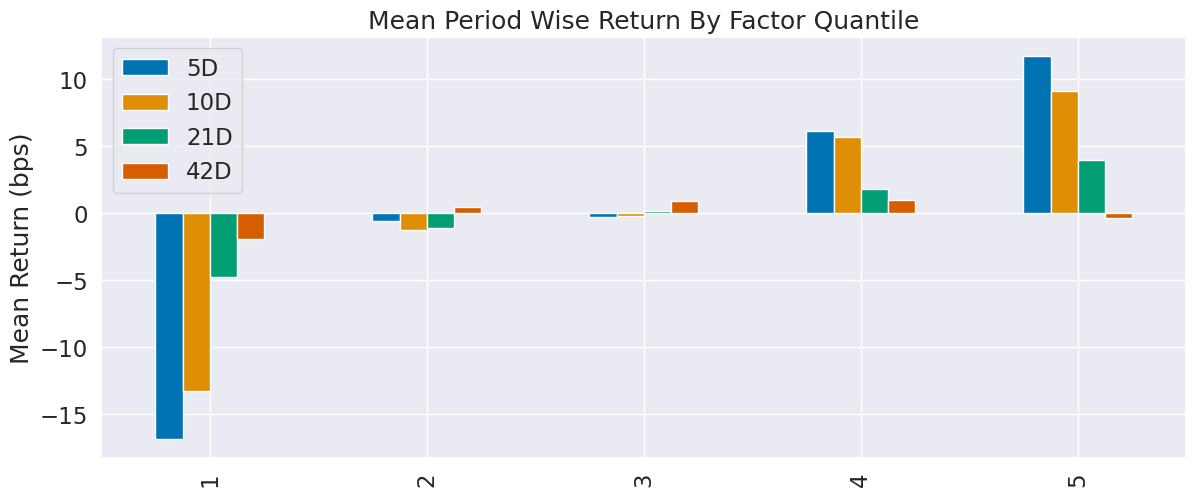

In [18]:
# Generate a summary tear sheet using the cleaned factor data, providing a comprehensive overview of the factor's performance.
create_summary_tear_sheet(alphalens_data)


### Analyzing Predictive Performance by Factor Quantiles: Returns Analysis

To effectively gauge the predictive performance of alpha factors, it is essential to examine the average returns generated by different factor quantiles. This analysis provides insights into how well the factor values correlate with actual asset performance across different segments.

#### Visualizing Average Period Returns by Factor Quantile
- **Function Utilization:** We leverage Alphalens’ built-in functions such as `mean_return_by_quantile` from the performance module. This function calculates the mean returns for assets within each quantile, providing a straightforward measure of average performance.
- **Bar Plot Visualization:** To make the analysis visually accessible, we use the `plot_quantile_returns_bar` from the plotting module. This function creates bar plots that depict the average returns for each quantile, making it easier to compare and contrast the performance across quantiles visually.

These tools allow us to not only quantify but also visualize the extent to which the factor values are indicative of future returns, enabling a more nuanced understanding of the factor's effectiveness in different market conditions.


In [19]:
# Calculate the mean returns by quantile and the standard error of the mean.
mean_return_by_q, std_err = mean_return_by_quantile(alphalens_data)

# Normalize the mean returns to reflect compounding over the periods.
mean_return_by_q_norm = mean_return_by_q.apply(lambda x: x.add(1).pow(1/int(x.name[:-1])).sub(1))


### Mean Return by Holding Period and Quintile

Analyzing the mean return by holding period and quintile offers a granular view of how different time frames and factor quantiles impact investment returns. This approach sheds light on the consistency and variability of alpha factors across different market conditions.

#### Visualization of Returns by Quintile and Holding Period
- **Bar Chart Analysis:** The bar chart generated in this section breaks down the mean forward returns for four distinct holding periods, categorized by the quintile of the factor signal. This visual representation helps in quickly identifying patterns and anomalies in the returns associated with each quantile.
- **Interpretation of Results:** As observed in the chart:
  - **Bottom Quintiles:** Generally, the assets in the lower quintiles, which represent weaker or negative predictive signals, exhibit more negative returns. This outcome validates the predictive quality of the factor, as poorer signals correlate with lower returns.
  - **Top Quintiles:** In contrast, the higher quintiles, indicative of stronger positive signals, usually show more positive returns, affirming the factor’s ability to identify profitable opportunities.
  - **Anomaly in Longest Holding Period:** Interestingly, the pattern tends to converge or become less distinct for the longest holding period. This observation could suggest diminishing predictability or the impact of external market factors over extended times.

This detailed breakdown not only enhances understanding of the factor's performance across different scenarios but also assists in fine-tuning investment strategies based on predictive signals.



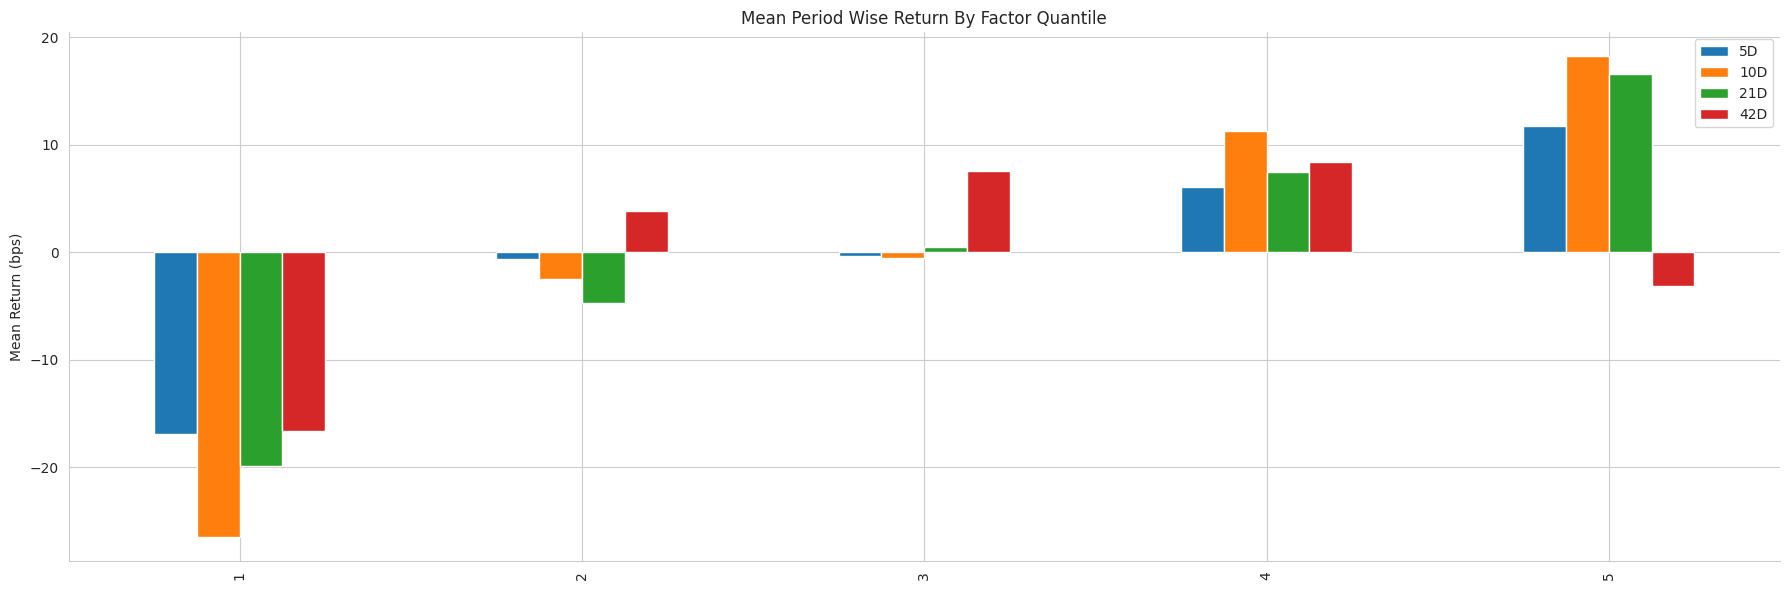

In [20]:
# Plot the mean returns by quantile as a bar chart.
plot_quantile_returns_bar(mean_return_by_q)

# Apply tight layout for better spacing in the plot and remove the spines for a cleaner look.
plt.tight_layout()
sns.despine();


### Detailed Performance Analysis Over Time by Signal Quintile

To deepen our understanding of how each signal quintile influences investment returns over time, particularly with the 10D and 5D holding periods, we examine the variations in returns in more specific intervals.

#### Insights into 10D Holding Period Performance
- **Quartile-Specific Observations:** The 10D holding period reveals nuanced performance variations across the quartiles:
  - **First and Fourth Quartiles:** These quartiles tend to show slightly better results compared to others. This suggests that the extremes of the factor signals (both high and low) might offer more distinct predictive power or market reactions within this specific timeframe.

#### Calculating Daily Returns for the 5D Holding Period
- **Approach to Daily Returns:** Instead of averaging returns, we calculate daily returns for the 5D holding period. This method provides a more granular view of the performance dynamics day by day, which is crucial for understanding short-term fluctuations and opportunities.
- **Adjustment for Holding Period Mismatch:** Alphalens offers functionality to adjust period returns to account for any discrepancies between the daily issuance of signals and the longer holding period. This adjustment ensures that the analysis remains accurate and reflective of actual investment outcomes.
  - **Documentation Reference:** For more detailed insights into how these adjustments are computed and their implications for your analysis, refer to the [Alphalens documentation](https://www.quantopian.com/almanac/docs).

This detailed temporal analysis allows investors to gauge the consistency and reliability of different quantiles over specified holding periods, aiding in more informed decision-making based on the predictive signals.


In [21]:
# Calculate the daily mean returns by quantile and the standard error.
mean_return_by_q_daily, std_err = mean_return_by_quantile(alphalens_data, by_date=True)


### Cumulative 5D Return Analysis

To visualize the long-term performance of different signal quintiles, we analyze the cumulative returns over a 5-day holding period. This approach helps in understanding how investments driven by various predictive signals perform over an extended timeframe.

#### Interpretation of the Cumulative Return Line Plot
- **Line Plot Insights:** The cumulative return line plot for the 5D holding period offers a clear comparison of the performance across different quintiles over a three-year period.
  - **Top Two Quintiles:** Throughout most of this period, investments based on the top two quintiles significantly outperformed those based on the bottom two quintiles. This consistent outperformance underscores the reliability of the predictive signals from the top quintiles.
  - **Fourth Quintile Performance:** Interestingly, the fourth quintile (just below the top quintile) demonstrated even better performance than the top quintile. This anomaly suggests that while the top signals are strong, there might be specific market conditions or factors that make the fourth quintile signals particularly effective during certain periods.

This cumulative analysis not only highlights the general predictive power of higher quintile signals but also provides insights into unique performance patterns that can inform more nuanced investment strategies.


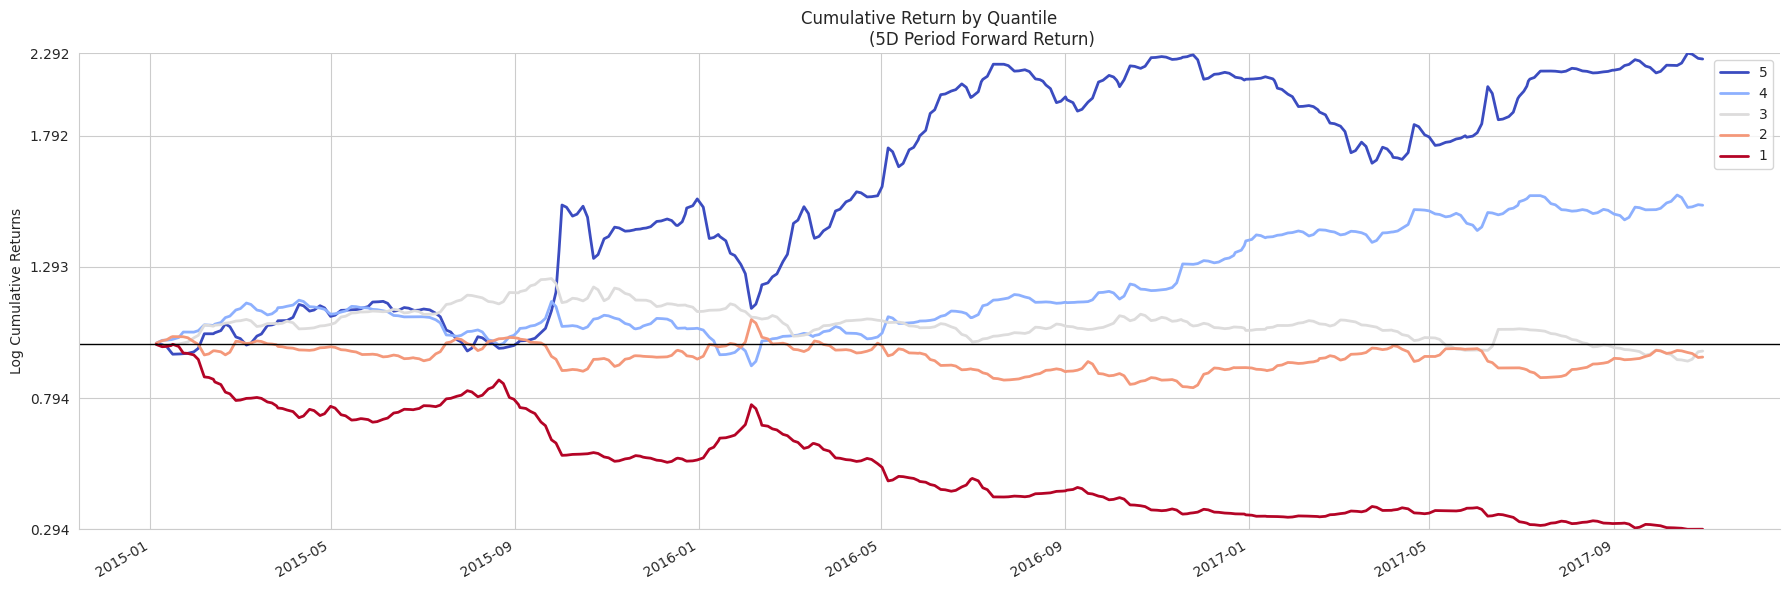

In [22]:
# Plot the cumulative returns by quantile for the 5-day period.
plot_cumulative_returns_by_quantile(mean_return_by_q_daily['5D'], period='5D', freq=None)

# Apply tight layout for the plot and remove the spines for aesthetic improvement.
plt.tight_layout()
sns.despine();


### Return Distribution by Holding Period and Quintile

Understanding the distribution of returns by holding period and quintile is crucial for assessing the variability and reliability of predictive signals. This section uses distributional plots to visualize the spread and separation of returns across different quintiles.

#### Insights from the Distributional Plot
- **Wide Range of Daily Returns:** The plot reveals that daily returns exhibit a broad range, indicating significant variability in performance on a day-to-day basis. This variability is inherent in financial markets and underscores the importance of considering the full distribution of returns rather than just average values.
- **Limited Distribution Separation:** Despite different mean returns across quintiles, the separation between the distributions is relatively limited. This observation suggests that, on any given day, the differences in performance between the various quintiles may not be very pronounced. Therefore, while certain quintiles may show better average performance over time, the daily differences can be subtle and influenced by short-term market fluctuations.

This analysis emphasizes the importance of looking at both the mean returns and the overall distribution to get a comprehensive view of the factor's predictive power and the associated risks.


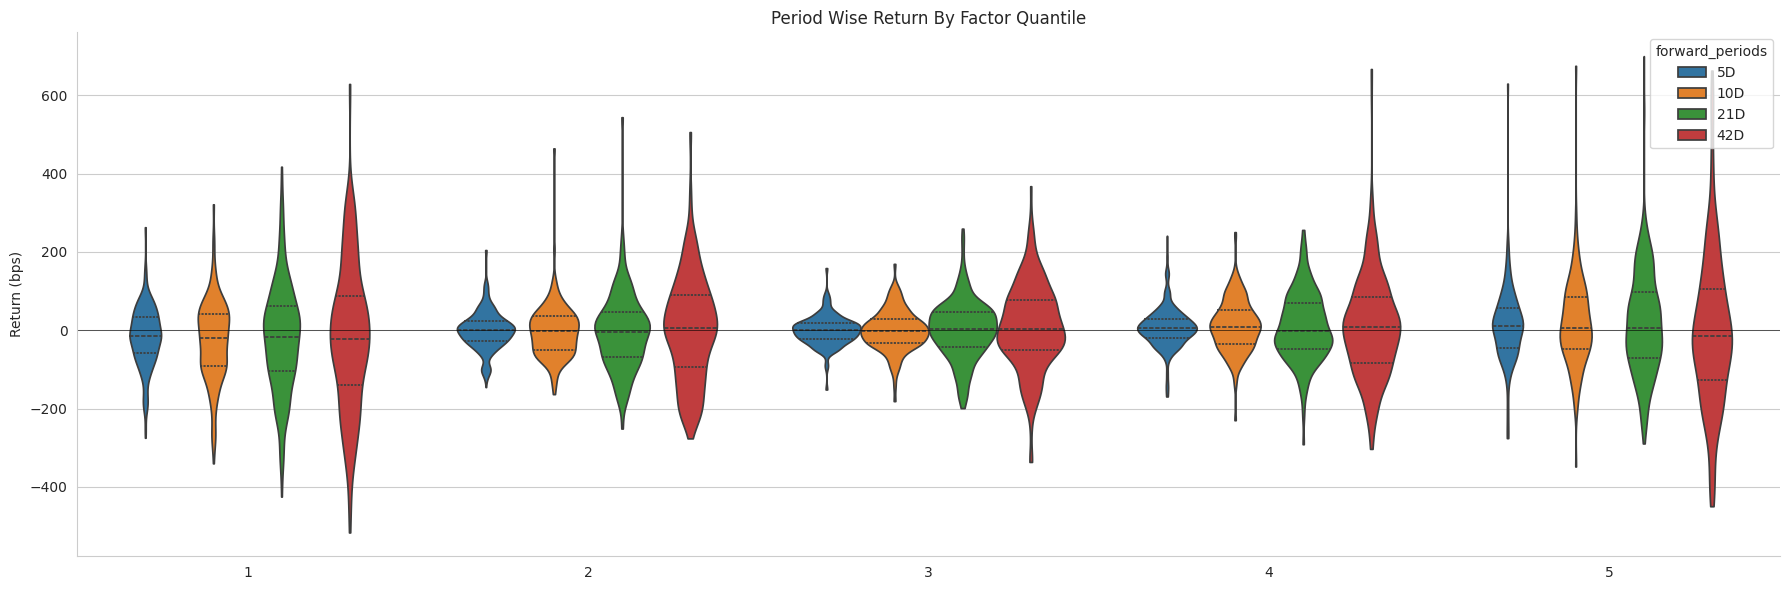

In [23]:
# Plot the distribution of quantile returns using a violin plot.
plot_quantile_returns_violin(mean_return_by_q_daily)

# Apply tight layout to the plot and remove the spines for visual clarity.
plt.tight_layout()
sns.despine();


### Understanding the Information Coefficient

In the realm of alpha factor design, particularly when employing machine learning models, it's vital to optimize predictive objectives. This section introduces key metrics used to evaluate the performance of an alpha factor, focusing on the Information Coefficient (IC) and related concepts.

#### Key Metrics for Alpha Factor Performance
- **Defining Alpha:** Alpha is defined as the average return in excess of a benchmark. It's a crucial measure of an investment strategy's ability to outperform the market or a specific benchmark.
- **Information Ratio (IR):** The IR is a metric that measures the average excess return per unit of risk. It is calculated by dividing alpha by the tracking risk. When the benchmark is the risk-free rate, the IR is equivalent to the Sharpe ratio, a well-known measure of risk-adjusted return.
- **Statistical Considerations:** In real-world scenarios, returns often do not follow a normal distribution. This section highlights the statistical issues that arise from this and explains the fundamental law of active management. The law breaks down the IR into a combination of forecasting skill and the strategy's ability to effectively leverage these skills.

### 5D Information Coefficient (Rolling Average)

The primary goal of alpha factors is to accurately predict the direction of future returns. A natural performance measure for this is the correlation between an alpha factor's predictions and the actual forward returns of the target assets.

- **Spearman Rank Correlation:** Instead of using the Pearson correlation, which measures linear relationships, it is more effective to use the non-parametric Spearman rank correlation coefficient. This coefficient assesses how well the relationship between two variables can be described using a monotonic function, making it more suitable for financial data.
- **Calculating Information Coefficient with Alphalens:** Alphalens utilizes the `scipy.stats.spearmanr` function to compute the Information Coefficient. The `factor_information_coefficient` function in Alphalens calculates the period-wise correlation, and the `plot_ic_ts` function creates a time-series plot with a one-month moving average.

This analysis provides a robust framework for evaluating the directional accuracy of alpha factors, offering valuable insights into their predictive power and stability over time.


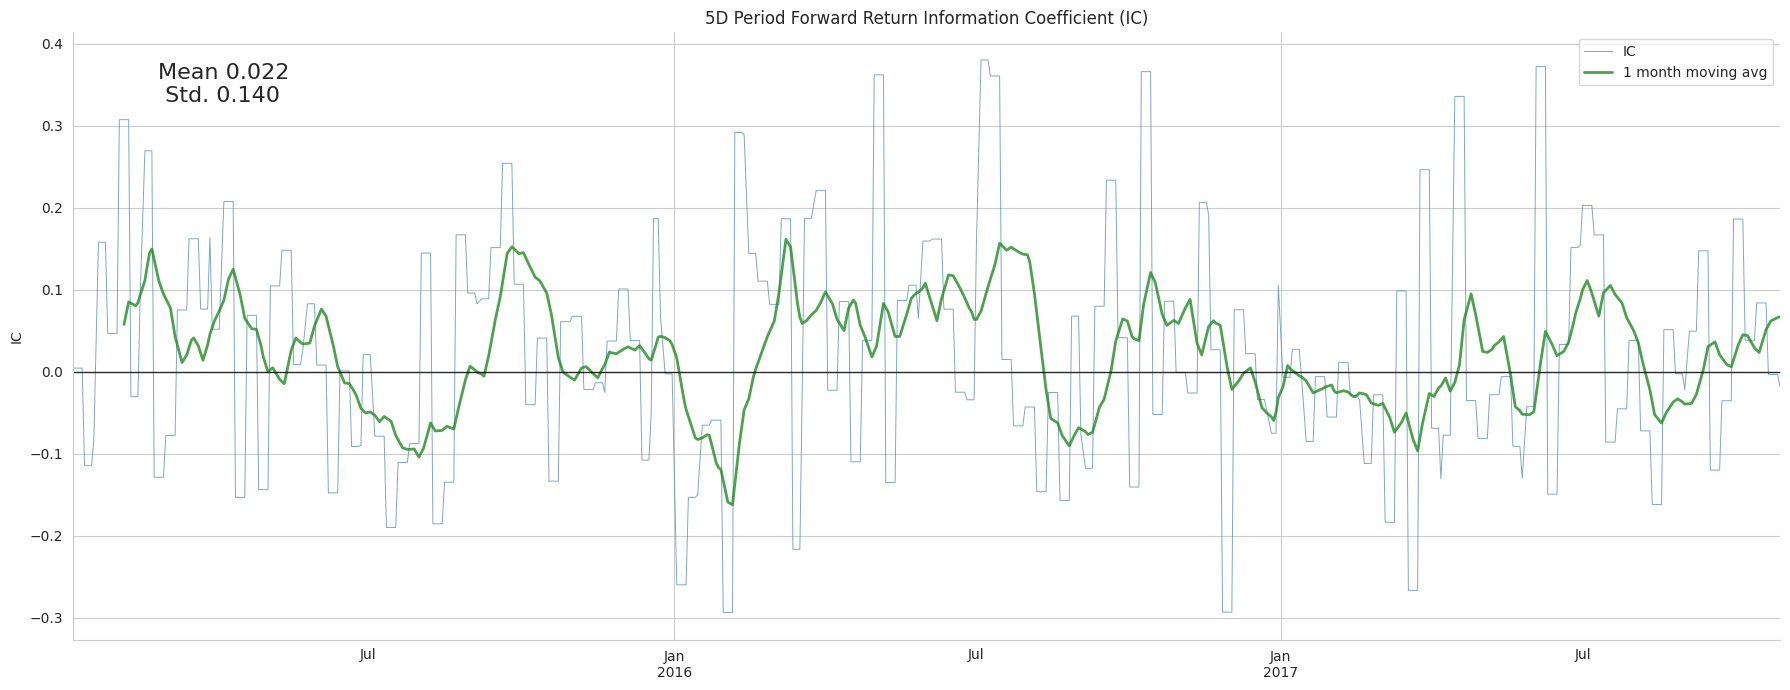

In [24]:
# Calculate the information coefficient of the factor data.
ic = factor_information_coefficient(alphalens_data)

# Plot the time series of the information coefficient.
plot_ic_ts(ic[['5D']])

# Apply tight layout to the plot and clean up the plot borders.
plt.tight_layout()
sns.despine();


### Information Coefficient by Holding Period

To thoroughly assess the predictive power of alpha factors, it is essential to examine the Information Coefficient (IC) over different holding periods. This analysis provides insights into the consistency and reliability of the factor's predictive abilities over time.

#### Time Series Plot of Moving-Average IC
- **Significance of Positive IC:** The time series plot of the moving-average IC reveals extended periods where the IC remains significantly positive. An IC value of 0.05 or even 0.1 can indicate substantial outperformance potential, assuming there are ample opportunities to leverage this forecasting skill.
- **Application of the Fundamental Law of Active Management:** This principle illustrates that a higher IC, even if modest, can lead to significant returns when combined with an effective investment strategy.

#### Annual Mean IC Plot
- **Historical Performance Analysis:** A plot of the annual mean IC helps highlight the historical performance of the factor. It shows how the predictive power of the factor has varied over different years, reflecting periods of strong and weak performance.
- **Understanding Variability:** This variability is crucial for comprehensively understanding the factor's effectiveness. Factors with consistently high ICs across years are generally more reliable, whereas those with fluctuating ICs might require further investigation to identify underlying causes.

These visualizations are key to understanding the temporal dynamics of alpha factors, allowing analysts to make informed decisions based on both short-term and long-term performance trends.


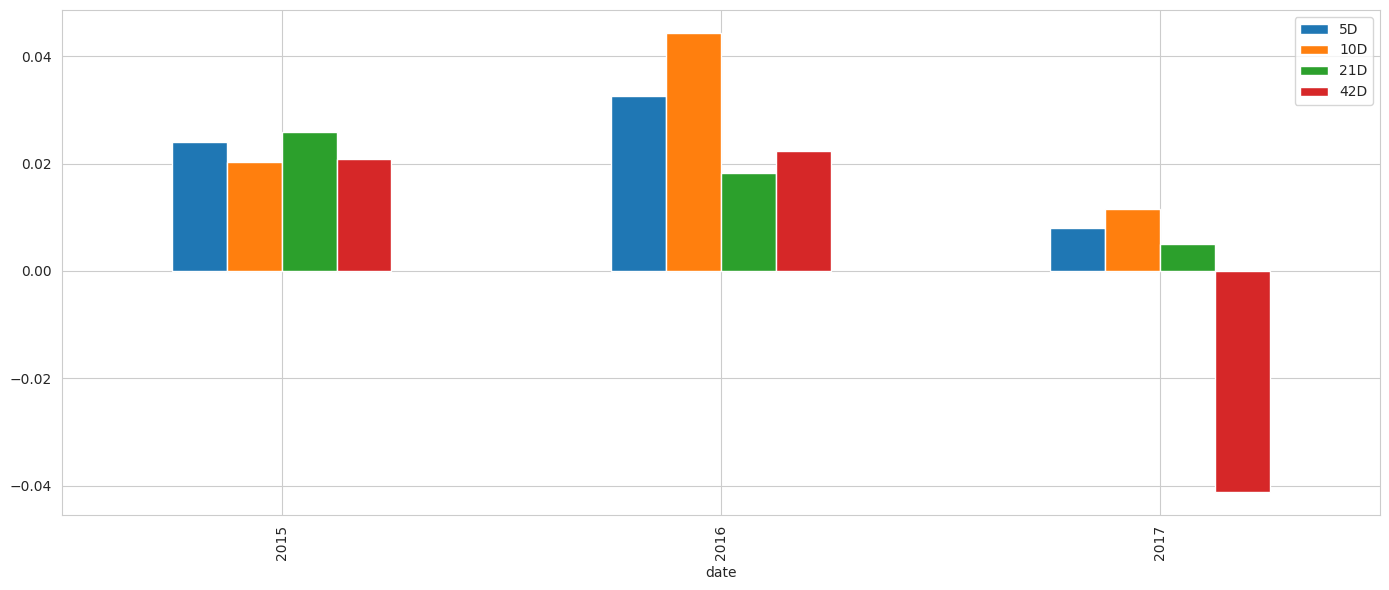

In [25]:
# Calculate the annual mean of the information coefficient.
ic = factor_information_coefficient(alphalens_data)
ic_by_year = ic.resample('A').mean()
ic_by_year.index = ic_by_year.index.year

# Plot the annual mean information coefficient as a bar chart.
ic_by_year.plot.bar(figsize=(14, 6))
plt.tight_layout();


### Turnover Tear Sheet

Factor turnover is a crucial metric in portfolio management as it quantifies the frequency at which assets associated with a given quantile change over time. Understanding turnover is essential for estimating the trading activity and associated costs required to maintain a portfolio aligned with the alpha signals.

#### Measuring Factor Turnover
- **Definition:** Factor turnover measures the proportion of assets currently in a specific factor quantile that were not in that quantile during the previous period. In other words, it shows how many trades are needed to adjust the portfolio to align with the updated factor signals.
- **Implications for Trading:** High turnover rates indicate frequent changes in the assets within a quantile, leading to increased trading activity. This can result in higher transaction costs and may affect the net returns of the strategy. Conversely, lower turnover rates suggest more stable quantile membership, potentially reducing trading costs.

#### Importance of Turnover Analysis
- **Cost Estimation:** By analyzing turnover, investors can estimate the potential trading costs associated with a particular strategy. High turnover strategies might incur significant costs, which need to be weighed against the expected returns.
- **Strategy Evaluation:** Turnover analysis helps in evaluating the practicality and efficiency of a trading strategy. Strategies with lower turnover might be preferred for their cost efficiency, while those with higher turnover might be justified by higher returns.

This section's turnover analysis provides a comprehensive view of the trading dynamics required by the factor signals, helping investors make informed decisions about the feasibility and cost implications of their strategies.


Turnover Analysis


,5D,10D,21D,42D
Quantile 1 Mean Turnover,0.411,0.590,0.830,0.831
Quantile 2 Mean Turnover,0.645,0.740,0.804,0.812
Quantile 3 Mean Turnover,0.679,0.765,0.808,0.812
Quantile 4 Mean Turnover,0.642,0.741,0.810,0.814
Quantile 5 Mean Turnover,0.394,0.569,0.811,0.819


,5D,10D,21D,42D
Mean Factor Rank Autocorrelation,0.713,0.454,-0.013,-0.017


<Figure size 640x480 with 0 Axes>

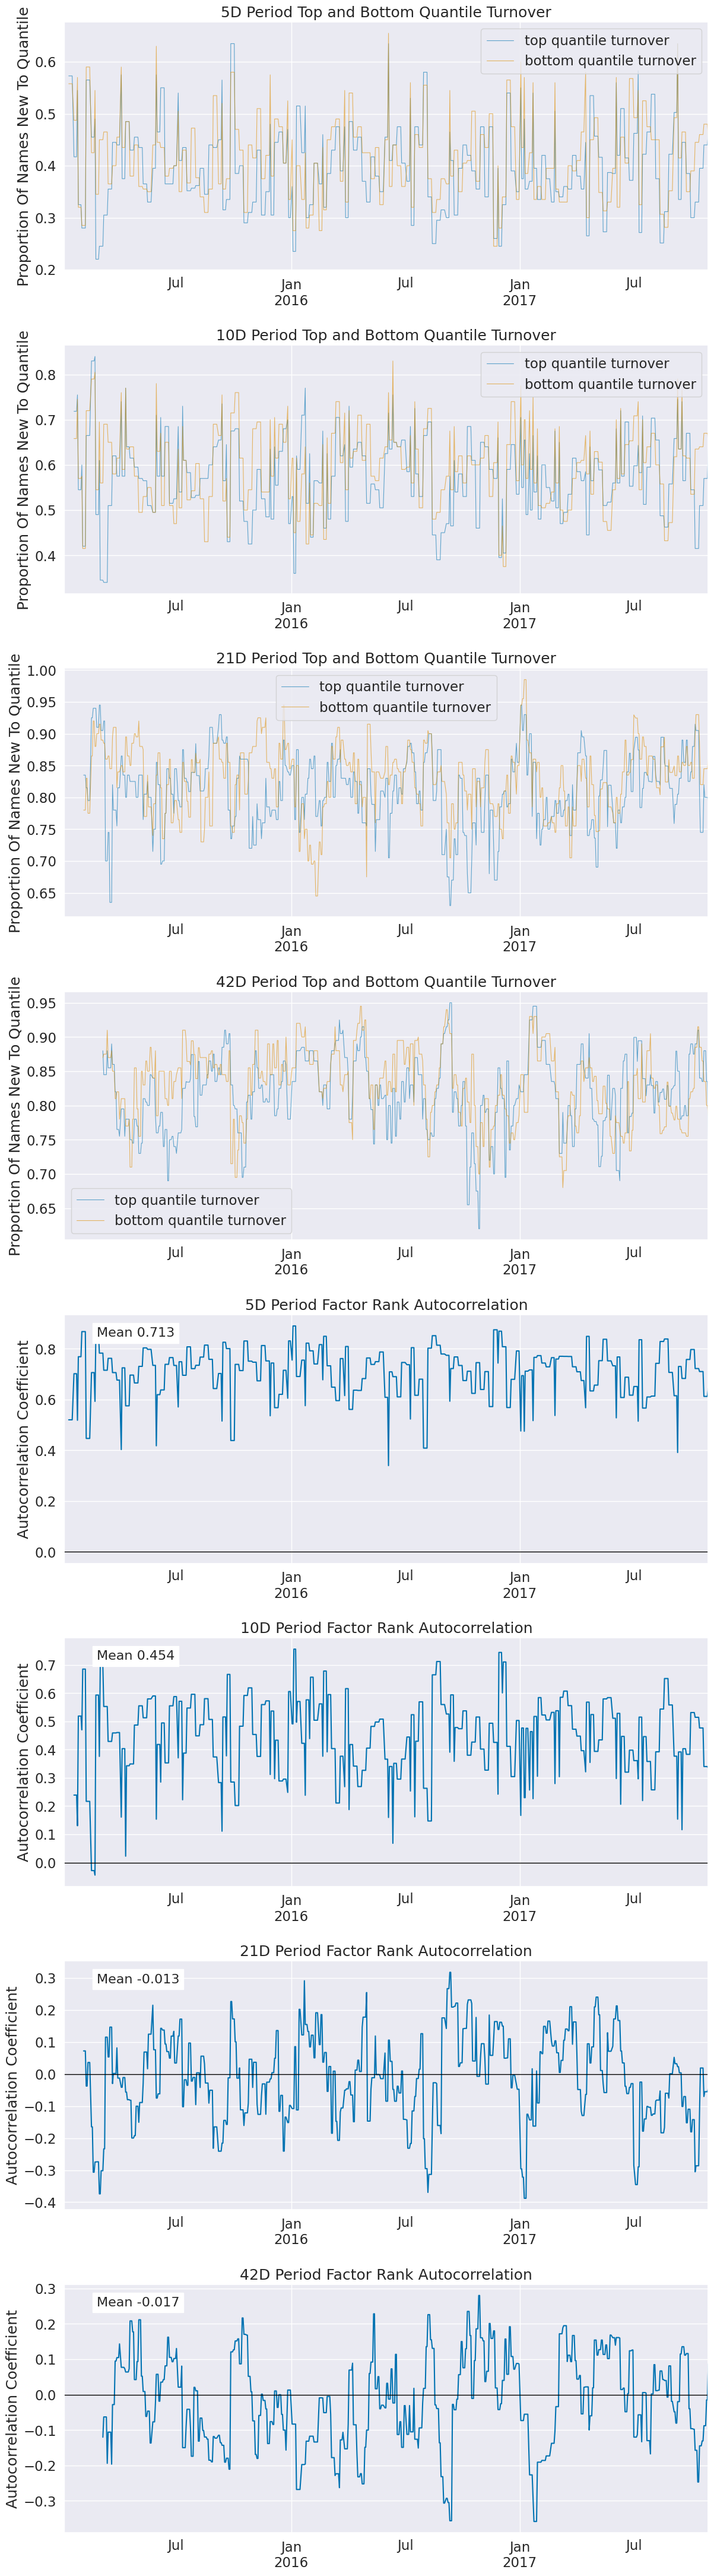

In [26]:
# Execute the function to create the turnover tear sheet for the provided alphalens data.
create_turnover_tear_sheet(alphalens_data);
